In [1]:
import torch

## 1. Simplified Attention

Say we want to compute self-attention output for 2nd token `x^2` in position, which is `journey`

### 1.1. Sample Toy Input

Word embedding are made to be just 3D dimensional

In [2]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

### 1.2. Steps

#### 1.2.1. Computing Attention Scores

Dot Product operation is used mathematically represent how two vectors are aligned
> Dot Product of query `x^2` with every other token in sequence

In [3]:
query = inputs[1]

attn_scores_2 = torch.empty(inputs.shape[0])

for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(query, x_i)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


#### 1.2.2. Normalise Attention Scores

* Main Goal behind the normalization to obtain attention weights which can sum to 1

* It makes it use full for convention and interpretation

We use softmax instead of summation function as it offers

* Positive Values -> Probability
* Favorable Gradient Properties

##### 1.2.2.1. Summation Normalisation [NOT USED]

In [4]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


##### 1.2.2.2. Softmax Normalisation

In [5]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())


## using pytorch inbuilt softmax function
attn_weights_2 = torch.nn.functional.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())



Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


#### 1.2.3. Updated Context Vector

This final step, updates initial context vector of `x^2` using attention weights derived in previous steps

In [6]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### 1.3. Matrix Form

#### 1.3.1. Attention Scores

In [7]:
## for loops which is slower

attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [8]:
## matrix multiplication which is faster
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


#### 1.3.2. Attention weights

In [9]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [10]:
attn_weights.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

#### 1.3.3. Updated Context Vector

In [11]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## 2. Self Attention [Q,K,V]

This form of self attention is used in Transformer architectures. let's start with same Toy Input

On a high level, self attention is way to update input token embeddings to account for context in the sequence. For Example, let's consider 3 Individual words

### 2.1. Single Input

In [12]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

### 2.2. Defining Query, Key and Value Matrix



In [13]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

### 2.3. Computing Q,K,V for Input Token

In [14]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


### 2.4. Key & Value for all tokens

In [15]:
keys = inputs @ W_key
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


### 2.5. Computing Attention Scores

Let `D` be dimension of Q, K, V projection matrices and `N` be sequence length, with Embedding being `P` dimensional


Query: Query Vector Of Input Token in Sequence: (1, D)
Keys: Key Vector Of all tokens in Sequence: (N, D)
Values: Value Vector for all tokens in Sequence: (N, D)

Attention_score = (1, D) dot (N, D) --> (N, 1)

In [18]:
attn_score_2 = query_2 @ keys.T
print("attn_score_2:", attn_score_2)

attn_score_2: tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


### 2.6. Scaling Attention Scores

Let $d_k$ be dimension of key vector and query vector (both have to be same), so when we take dot product

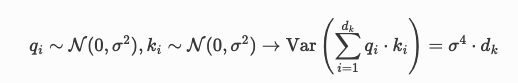



Attention score would now have variance of $\sigma^4 . d_k$, In order stablise variance so that it is approximately 1 thorughout the model, attention score is divided by $ \sqrt{d_k} $ 

> Note: $ \sigma^4$ is ignored as it around 1

In [19]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_score_2 / (d_k ** 0.5), dim=-1)
print("attn_weights_2:", attn_weights_2)

attn_weights_2: tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


### 2.7. Updating Context Vector

In [21]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


## 3. PyTorch Implementaion

In [22]:
import torch.nn as nn

### 3.1. Using nn.Paramter for Q, K, V Weight matrix

In [23]:
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):

        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        d = keys.shape[1]

        attn_scores = queries @ keys.T
        scaled_attn_scores = attn_scores / (d ** 0.5)
        attn_weights = torch.softmax(scaled_attn_scores, dim=-1)

        context_vec = attn_weights @ values

        return context_vec

In [24]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


### 3.2. Using nn.Linear Object

In [ ]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=False)
        self.W_key = nn.Linear(d_in, d_out, bias=False)
        self.W_value = nn.Linear(d_in, d_out, bias=False)

    def forward(self, x):

        query = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        d = keys.shape[1]
        pass

In [26]:
W_query = nn.Linear(d_in, d_out, bias=False)
W_key = nn.Linear(d_in, d_out, bias=False)
W_value = nn.Linear(d_in, d_out, bias=False)

In [ ]:
querW_query(inputs).shape[1]

2

In [30]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])